Importamos las librerías

In [1]:
from typing import Dict
import jax
import numpy as np
import pinnsjax
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import logging

## Funciones auxuliares

Estas funciones se usan para hacer el gráfico final. Unas funciones muy similares están y implementadas en el propio paquete pinnsjax, pero casuaban un error. Simplemente las copié aquí modificando ligeramente el problema.

In [ ]:
def figsize(scale, nplots=1):
    """Calculate the figure size based on a given scale and number of plots.

    :param scale: Scaling factor for the figure size.
    :param nplots: Number of subplots in the figure (default is 1).
    :return: Calculated figure size in inches.
    """

    fig_width_pt = 390.0  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = nplots * fig_width * golden_mean  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size


def newfig(width, nplots=1):
    """Create a new figure with a specified width and number of subplots.

    :param width: Width of the figure.
    :param nplots: Number of subplots in the figure (default is 1).
    :return: Created figure and subplot axis.
    """

    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax


def savefig(filename, crop=True):
    """Save a figure to the specified filename with optional cropping.

    :param filename: Name of the output file (without extension).
    :param crop: Whether to apply tight cropping to the saved image (default is True).
    """

    log.info(f"Image saved at {filename}")

    dir_name = os.path.dirname(filename)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)

    if crop:
        plt.savefig(f"{filename}.pdf", bbox_inches="tight", pad_inches=0)
        plt.savefig(f"{filename}.eps", bbox_inches="tight", pad_inches=0)
    else:
        plt.savefig(f"{filename}.pdf")
        plt.savefig(f"{filename}.eps")


def plot_resultados(mesh, preds, train_datasets, val_dataset, file_name):
    """
    Esta función está implementada dentro del propio paquete, pero parece que contenía algún error que causaba un mal funcionamiento.
    Esta función es la misma pero ligeramente modificada para que funcione correctamente
    """

    U_pred = preds["u"]
    exact_u = mesh.solution["u"]
    x = mesh.spatial_domain[:]
    x_i, t_i, _ = train_datasets[1][:]
    x_b, t_b, _ = train_datasets[2][:]

    U_pred = U_pred.reshape(exact_u.shape)
    X_u_train = np.vstack([x_i[0], x_b[0]])

    X_u_time = np.vstack([t_i, t_b])

    X_u_train = np.hstack([X_u_train, X_u_time])
    fig, ax = newfig(1.5, 0.9)
    ax.axis("off")

    # Row 0: u(t,x)
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1 - 0.06, bottom=1 - 1 / 3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(
        U_pred,
        interpolation="nearest",
        cmap="rainbow",
        extent=[
            mesh.time_domain[:].min(),
            mesh.time_domain[:].max(),
            mesh.spatial_domain[:].min(),
            mesh.spatial_domain[:].max(),
        ],
        origin="lower",
        aspect="auto",
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(
        X_u_train[:, 1],
        X_u_train[:, 0],
        "kx",
        #label="Datos (%d puntos)" % (X_u_train.shape[0]),
        markersize=4,
        clip_on=False,
    )

    line = np.linspace(mesh.spatial_domain[:].min(), mesh.spatial_domain[:].max(), 2)[:, None]
    ax.plot(mesh.time_domain[25] * np.ones((2, 1)), line, "w-", linewidth=1)
    ax.plot(mesh.time_domain[50] * np.ones((2, 1)), line, "w-", linewidth=1)
    ax.plot(mesh.time_domain[75] * np.ones((2, 1)), line, "w-", linewidth=1)

    ax.set_xlabel("$t$")
    ax.set_ylabel("$x$")
    ax.legend(frameon=False, loc="best")
    ax.set_title("$u(x,t)$", fontsize=10)

    # Row 1: u(t,x) slices
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1 - 1 / 3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x, exact_u[:, 25], "b-", linewidth=2, label="Solución real (FDM)")
    ax.plot(x, U_pred[:, 25], "r--", linewidth=2, label="Predicción")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x,t)$")
    ax.set_title("$t = 0.025$", fontsize=10)
    ax.axis("square")
    ax.set_xlim([0, 2])
    ax.set_ylim([-1, 1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x, exact_u[:, 50], "b-", linewidth=2, label="Solución real (FDM)")
    ax.plot(x, U_pred[:, 50], "r--", linewidth=2, label="Predicción")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x,t)$")
    ax.axis("square")
    ax.set_xlim([0, 2])
    ax.set_ylim([-1, 1])
    ax.set_title("$t = 0.050$", fontsize=10)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x, exact_u[:, 75], "b-", linewidth=2, label="Solución real (FDM)")
    ax.plot(x, U_pred[:, 75], "r--", linewidth=2, label="Predicción")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x,t)$")
    ax.axis("square")
    ax.set_xlim([0, 2])
    ax.set_ylim([-1, 1])
    ax.set_title("$t = 0.075$", fontsize=10)

    plt.savefig(file_name + "/fig_descubrimiento.pdf", bbox_inches = 'tight')
    plt.show()

# Sin ruido

In [ ]:
porcentaje_error = 0

Leemos los datos reales

In [2]:
u = np.genfromtxt('generacion_datos/data/u_real_t_1e-8_x_1e-2.csv', delimiter=',')

Definimos una función para meter los datos a la red

In [ ]:
def read_data_fn(_):

    exact_u = np.real(u) # T x N

    return {"u": exact_u}

Definimos los dominios temporales y espaciales

In [ ]:
time_domain = pinnsjax.data.TimeDomain(t_interval=[0, 0.1], t_points = 100)
spatial_domain = pinnsjax.data.Interval(x_interval=[0, 2], shape = [200, 1])

Definimos el mesh

In [ ]:
mesh = pinnsjax.data.Mesh(root_dir='data',
                          read_data_fn=read_data_fn,
                          spatial_domain = spatial_domain,
                          time_domain = time_domain)

Seleccionamos algunos puntos de la condición inicial al azar para incorporar a la red como datos de entrenamiento

In [ ]:
N0 = 100
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      solution = ['u'])

Seleccionamos puntos dentro del dominio, esta vez para añadirlo al conjunto de entrenamiento

In [ ]:
N_b = 2000
di_b = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_b,
                                 solution = ['u'])

Seleccionamos punto al azar para evaluar la pérdida física

In [ ]:
N_f = 10000
me_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_f,
                                 collection_points = ['f_u'])

Seleccionamos todo el dominio como conjunto de validación

In [ ]:
val_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                  solution = ['u'])

Definimos nuestra red nueronal

In [ ]:
net = pinnsjax.models.FCN(layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
                          output_names = ['u'],
                          lb=mesh.lb,
                          ub=mesh.ub)

In [ ]:
k = 0.5
c = 0.3

In [ ]:
k/c

1.6666666666666667

Inicializamos los parámetros en 1 y la EDP que domina el el sistema como una función. Hallamos las derivadas con autodiferenciación. Los parámetros los metemos en un diccionario porque de esta forma los podemos incorporar a la red

In [ ]:
params = {'k/c': 1.0}

In [ ]:
def pde_fn(functional_model,
           params,
           outputs: Dict[str, jax.Array],
           x: jax.Array,
           t: jax.Array):

    u_x, u_t = pinnsjax.utils.gradient(functional_model, argnums=(1, 2), order=1)(params, x, t, 'u')
    u_xx = pinnsjax.utils.gradient(functional_model, argnums=1, order=2)(params, x, t, 'u')[0]

    outputs["f_u"] = u_t - params['k/c'] * u_xx

    return outputs

Definimos el datamodule, que gestiona los conjuntos de datos

In [ ]:
train_datasets = [me_s, in_c, di_b]
val_dataset = val_s
datamodule = pinnsjax.data.PINNDataModule(train_datasets = train_datasets,
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

Definimos el modelo proporcionando la red neuronal, la EDP y la función de pérdida

In [ ]:
model = pinnsjax.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   loss_fn = 'mse',
                                   extra_variables = params)

Ajustamos el trainer y entrenamos a la red

In [ ]:
trainer = pinnsjax.Trainer(max_epochs=200000, check_val_every_n_epoch=1000)

In [ ]:
trainer.fit(model=model, datamodule=datamodule)

200000/200000 100%|██████████|[28:40<00:00, 116.25it/s, val/loss: 0.0000, val/error_u: 0.0134, train/loss: 0.0007, k/c: 1.6329: ]


Obtenemos la predicción de cada red para todo el dominio espacial y temporal

In [ ]:
preds_dict = trainer.predict(model=model, datamodule=datamodule)
type(preds_dict)

dict

<ipython-input-4-29ab3e64336b>:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


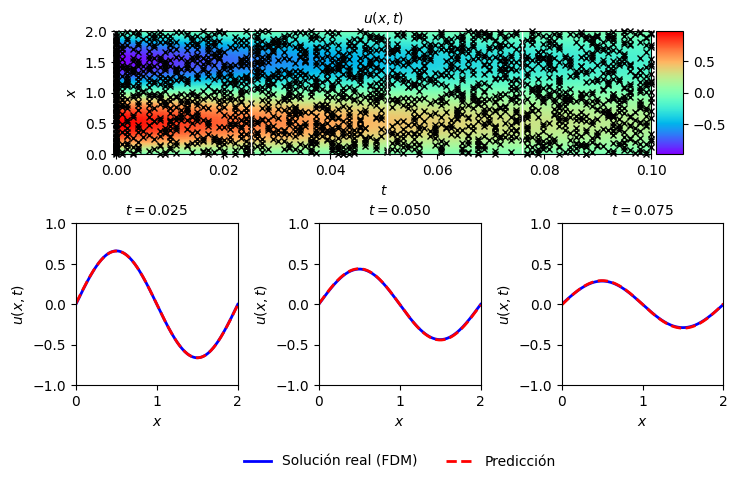

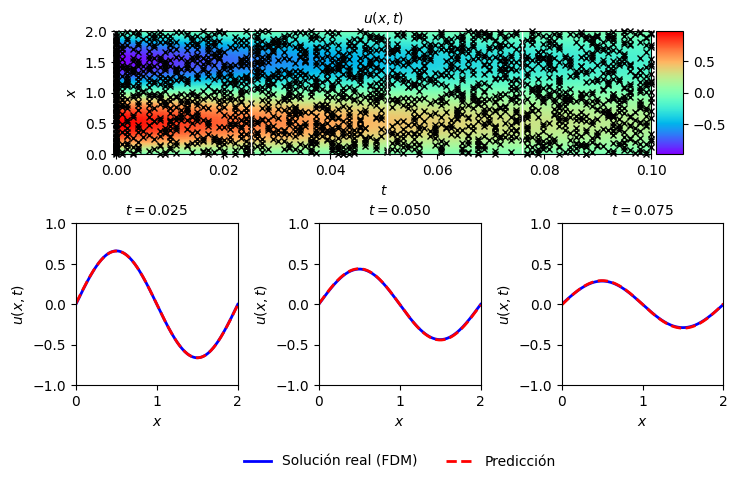

In [ ]:
plot_resultados(mesh=mesh,
                preds=preds_dict,
                train_datasets=train_datasets,
                val_dataset=val_dataset,
                file_name=f'Descubrimiento basado en datos/error_{porcentaje_error}')


In [ ]:
file_name = f'Descubrimiento basado en datos/error_{porcentaje_error}/descubrimientos_u_pred_t_1e-8_x_1e-2.csv'

with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(preds_dict['u'])

print(f"Matriz guardada en {file_name}")

Matriz guardada en /content/drive/MyDrive/data/Segunda vez/descubrimientos/error_0/descubrimientos_u_pred_t_1e-8_x_1e-2.csv


# Añadimos ruido

En los siguientes casos añadimos un ruido gaussiano a los datos con una desviación típica igual a un cierto porcentaje del valor de la función en cada punto

## 10 %

In [ ]:
u = np.genfromtxt('generacion_datos/data/u_real_t_1e-8_x_1e-2.csv', delimiter=',')

In [ ]:
porcentaje_error = 10
u_10 = np.random.normal(u, np.abs(u * porcentaje_error/100), u.shape)
print(u[0:3, 0], "\n", u_10[0:3, 0])

[0.         0.03156855 0.06310563] 
 [0.         0.0300832  0.07027603]


In [ ]:
def read_data_fn_10(_):

    exact_u = np.real(u_10) # T x N

    return {"u": exact_u}

In [ ]:
mesh = pinnsjax.data.Mesh(root_dir='data',
                          read_data_fn=read_data_fn_10,
                          spatial_domain = spatial_domain,
                          time_domain = time_domain)

In [ ]:
N0 = 100

In [ ]:
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      solution = ['u'])

In [ ]:
N_b = 2000
di_b = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_b,
                                 solution = ['u'])

In [ ]:
N_f = 10000
me_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_f,
                                 collection_points = ['f_u'])

In [ ]:
val_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                  solution = ['u'])

In [ ]:
net = pinnsjax.models.FCN(layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
                          output_names = ['u'],
                          lb=mesh.lb,
                          ub=mesh.ub)

In [ ]:
k = 0.5
c = 0.3

In [ ]:
k/c

1.6666666666666667

In [ ]:
params = {'k/c': 1.0}

In [ ]:
def pde_fn(functional_model,
           params,
           outputs: Dict[str, jax.Array],
           x: jax.Array,
           t: jax.Array):

    u_x, u_t = pinnsjax.utils.gradient(functional_model, argnums=(1, 2), order=1)(params, x, t, 'u')
    u_xx = pinnsjax.utils.gradient(functional_model, argnums=1, order=2)(params, x, t, 'u')[0]

    outputs["f_u"] = u_t - params['k/c'] * u_xx

    return outputs

In [ ]:
train_datasets = [me_s, in_c, di_b]
val_dataset = val_s
datamodule = pinnsjax.data.PINNDataModule(train_datasets = train_datasets,
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

In [ ]:
model = pinnsjax.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   loss_fn = 'mse',
                                   extra_variables = params)

In [ ]:
trainer = pinnsjax.Trainer(max_epochs=200000, check_val_every_n_epoch=1000)

In [ ]:
trainer.fit(model=model, datamodule=datamodule)

200000/200000 100%|██████████|[28:34<00:00, 116.64it/s, val/loss: 0.0016, val/error_u: 0.1024, train/loss: 0.0081, k/c: 1.5784: ]


In [ ]:
trainer.validate(model=model, datamodule=datamodule)

(Array(0.00156267, dtype=float32), {'u': Array(0.1026275, dtype=float32)})

In [ ]:
preds_dict = trainer.predict(model=model, datamodule=datamodule)
type(preds_dict)

dict

<ipython-input-4-29ab3e64336b>:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


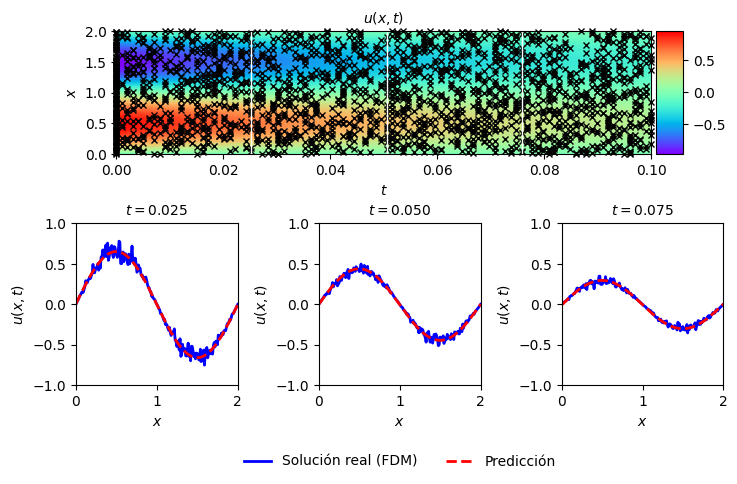

In [ ]:
plot_resultados(mesh=mesh,
                preds=preds_dict,
                train_datasets=train_datasets,
                val_dataset=val_dataset,
                file_name=f'Descubrimiento basado en datos/error_{porcentaje_error}')


In [ ]:
params

{'k/c': 1.0}

In [ ]:
# Nombre del archivo CSV
file_name = f'Descubrimiento basado en datos/error_{porcentaje_error}/descubrimiento_u_pred_t_1e-8_x_1e-2_error_{porcentaje_error}.csv'

# Escribir la matriz en el archivo CSV
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(preds_dict['u'])

print(f"Matriz guardada en {file_name}")

Matriz guardada en /content/drive/MyDrive/data/Segunda vez/descubrimientos/error_10/descubrimiento_u_pred_t_1e-8_x_1e-2_error_10.csv


In [ ]:
u_real = u.flatten()
u_pred = trainer.predict(model=model, datamodule=datamodule)['u']

In [ ]:
error_absoluto_medio = np.abs(u_real-u_pred).mean()
print(error_absoluto_medio)

0.4339983


## 5 %

In [ ]:
u = np.genfromtxt('generacion_datos/data/u_real_t_1e-8_x_1e-2.csv', delimiter=',')

In [ ]:
porcentaje_error = 5
u_5 = np.random.normal(u, np.abs(u * porcentaje_error/100), u.shape)
print(u[0:3, 0], "\n", u_5[0:3, 0])

[0.         0.03156855 0.06310563] 
 [0.         0.03133788 0.06559083]


In [ ]:
def read_data_fn_5(_):

    exact_u = np.real(u_5) # T x N

    return {"u": exact_u}

In [ ]:
mesh = pinnsjax.data.Mesh(root_dir='data',
                          read_data_fn=read_data_fn_5,
                          spatial_domain = spatial_domain,
                          time_domain = time_domain)

In [ ]:
N0 = 100
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      solution = ['u'])

In [ ]:
N_b = 2000
di_b = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_b,
                                 solution = ['u'])

In [ ]:
N_f = 10000
me_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_f,
                                 collection_points = ['f_u'])

In [ ]:
val_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                  solution = ['u'])

In [ ]:
net = pinnsjax.models.FCN(layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
                          output_names = ['u'],
                          lb=mesh.lb,
                          ub=mesh.ub)

In [ ]:
k = 0.5
c = 0.3

In [ ]:
k/c

1.6666666666666667

In [ ]:
params = {'k/c': 1.0}

In [ ]:
def pde_fn(functional_model,
           params,
           outputs: Dict[str, jax.Array],
           x: jax.Array,
           t: jax.Array):

    u_x, u_t = pinnsjax.utils.gradient(functional_model, argnums=(1, 2), order=1)(params, x, t, 'u')
    u_xx = pinnsjax.utils.gradient(functional_model, argnums=1, order=2)(params, x, t, 'u')[0]

    outputs["f_u"] = u_t - params['k/c'] * u_xx

    return outputs

In [ ]:
train_datasets = [me_s, in_c, di_b]
val_dataset = val_s
datamodule = pinnsjax.data.PINNDataModule(train_datasets = train_datasets,
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

In [ ]:
model = pinnsjax.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   loss_fn = 'mse',
                                   extra_variables = params)

In [ ]:
trainer = pinnsjax.Trainer(max_epochs=200000, check_val_every_n_epoch=1000)

In [ ]:
trainer.fit(model=model, datamodule=datamodule)

200000/200000 100%|██████████|[28:34<00:00, 116.63it/s, val/loss: 0.0004, val/error_u: 0.0520, train/loss: 0.0033, k/c: 1.6509: ]


In [ ]:
trainer.validate(model=model, datamodule=datamodule)

(Array(0.00039127, dtype=float32), {'u': Array(0.05160673, dtype=float32)})

In [ ]:
preds_dict = trainer.predict(model=model, datamodule=datamodule)
type(preds_dict)

dict

<ipython-input-4-29ab3e64336b>:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


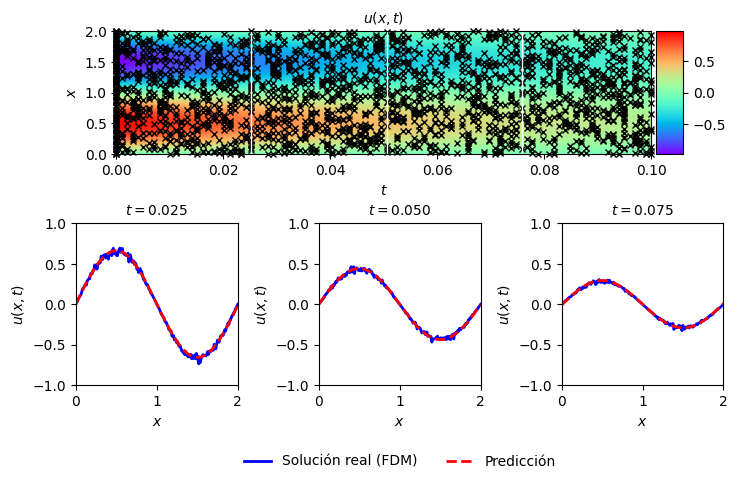

In [ ]:
plot_resultados(mesh=mesh,
                preds=preds_dict,
                train_datasets=train_datasets,
                val_dataset=val_dataset,
                file_name=f'Descubrimiento basado en datos/error_{porcentaje_error}')


In [ ]:
params

{'k/c': 1.0}

In [ ]:
# Nombre del archivo CSV
file_name = f'Descubrimiento basado en datos/error_{porcentaje_error}/descubrimiento_u_pred_t_1e-8_x_1e-2_error_{porcentaje_error}.csv'

# Escribir la matriz en el archivo CSV
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(preds_dict['u'])

print(f"Matriz guardada en {file_name}")

Matriz guardada en /content/drive/MyDrive/data/Segunda vez/descubrimientos/error_5/descubrimiento_u_pred_t_1e-8_x_1e-2_error_5.csv


## 3%

In [ ]:
u = np.genfromtxt('generacion_datos/data/u_real_t_1e-8_x_1e-2.csv', delimiter=',')

In [ ]:
porcentaje_error = 3
u_3 = np.random.normal(u, np.abs(u * porcentaje_error/100), u.shape)
print(u[0:3, 0], "\n", u_3[0:3, 0])

[0.         0.03156855 0.06310563] 
 [0.         0.02993973 0.06152758]


In [ ]:
def read_data_fn_3(_):

    exact_u = np.real(u_3) # T x N

    return {"u": exact_u}

In [ ]:
mesh = pinnsjax.data.Mesh(root_dir='data',
                          read_data_fn=read_data_fn_3,
                          spatial_domain = spatial_domain,
                          time_domain = time_domain)

In [ ]:
N0 = 100
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      solution = ['u'])

In [ ]:
N_b = 2000
di_b = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_b,
                                 solution = ['u'])

In [ ]:
N_f = 10000
me_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_f,
                                 collection_points = ['f_u'])

In [ ]:
val_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                  solution = ['u'])

In [ ]:
net = pinnsjax.models.FCN(layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
                          output_names = ['u'],
                          lb=mesh.lb,
                          ub=mesh.ub)

In [ ]:
k = 0.5
c = 0.3

In [ ]:
k/c

1.6666666666666667

In [ ]:
params = {'k/c': 1.0}

In [ ]:
def pde_fn(functional_model,
           params,
           outputs: Dict[str, jax.Array],
           x: jax.Array,
           t: jax.Array):

    u_x, u_t = pinnsjax.utils.gradient(functional_model, argnums=(1, 2), order=1)(params, x, t, 'u')
    u_xx = pinnsjax.utils.gradient(functional_model, argnums=1, order=2)(params, x, t, 'u')[0]

    outputs["f_u"] = u_t - params['k/c'] * u_xx

    return outputs

In [ ]:
train_datasets = [me_s, in_c, di_b]
val_dataset = val_s
datamodule = pinnsjax.data.PINNDataModule(train_datasets = train_datasets,
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

In [ ]:
model = pinnsjax.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   loss_fn = 'mse',
                                   extra_variables = params)

In [ ]:
trainer = pinnsjax.Trainer(max_epochs=200000, check_val_every_n_epoch=1000)

In [ ]:
trainer.fit(model=model, datamodule=datamodule)

200000/200000 100%|██████████|[28:33<00:00, 116.71it/s, val/loss: 0.0002, val/error_u: 0.0325, train/loss: 0.0023, k/c: 1.6382: ]


In [ ]:
trainer.validate(model=model, datamodule=datamodule)

(Array(0.00016288, dtype=float32), {'u': Array(0.03329412, dtype=float32)})

In [ ]:
preds_dict = trainer.predict(model=model, datamodule=datamodule)
type(preds_dict)

dict

<ipython-input-4-29ab3e64336b>:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


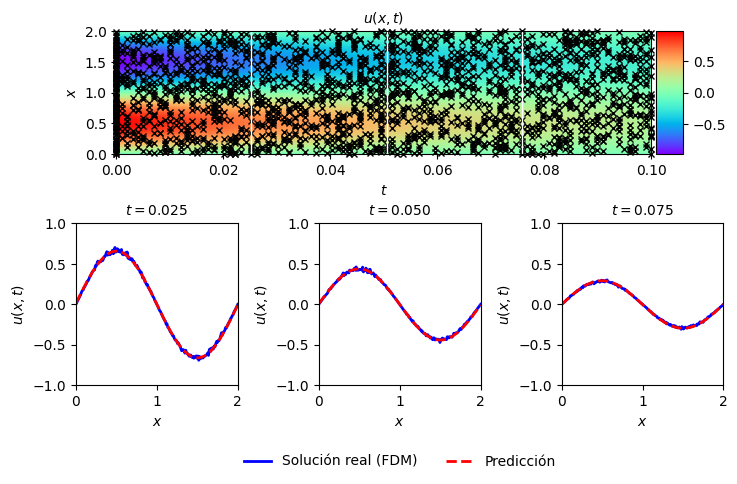

In [ ]:
plot_resultados(mesh=mesh,
                preds=preds_dict,
                train_datasets=train_datasets,
                val_dataset=val_dataset,
                file_name=f'Descubrimiento basado en datos/error_{porcentaje_error}')


In [ ]:
params

{'k/c': 1.0}

In [ ]:
# Nombre del archivo CSV
file_name = f'Descubrimiento basado en datos/error_{porcentaje_error}/descubrimiento_u_pred_t_1e-8_x_1e-2_error_{porcentaje_error}.csv'

# Escribir la matriz en el archivo CSV
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(preds_dict['u'])

print(f"Matriz guardada en {file_name}")

Matriz guardada en /content/drive/MyDrive/data/Segunda vez/descubrimientos/error_3/descubrimiento_u_pred_t_1e-8_x_1e-2_error_3.csv


## 1%

In [ ]:
u = np.genfromtxt('generacion_datos/data/u_real_t_1e-8_x_1e-2.csv', delimiter=',')

In [ ]:
porcentaje_error = 1
u_1 = np.random.normal(u, np.abs(u * porcentaje_error/100), u.shape)
print(u[0:3, 0], "\n", u_1[0:3, 0])

[0.         0.03156855 0.06310563] 
 [0.         0.03194845 0.06309424]


In [ ]:
def read_data_fn_1(_):

    exact_u = np.real(u_1) # T x N

    return {"u": exact_u}

In [ ]:
mesh = pinnsjax.data.Mesh(root_dir='data',
                          read_data_fn=read_data_fn_1,
                          spatial_domain = spatial_domain,
                          time_domain = time_domain)

In [ ]:
N0 = 100
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      solution = ['u'])

In [ ]:
N_b = 2000
di_b = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_b,
                                 solution = ['u'])

In [ ]:
N_f = 10000
me_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_f,
                                 collection_points = ['f_u'])

In [ ]:
val_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                  solution = ['u'])

In [ ]:
net = pinnsjax.models.FCN(layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
                          output_names = ['u'],
                          lb=mesh.lb,
                          ub=mesh.ub)

In [ ]:
k = 0.5
c = 0.3

In [ ]:
k/c

1.6666666666666667

In [ ]:
params = {'k/c': 1.0}

In [ ]:
def pde_fn(functional_model,
           params,
           outputs: Dict[str, jax.Array],
           x: jax.Array,
           t: jax.Array):

    u_x, u_t = pinnsjax.utils.gradient(functional_model, argnums=(1, 2), order=1)(params, x, t, 'u')
    u_xx = pinnsjax.utils.gradient(functional_model, argnums=1, order=2)(params, x, t, 'u')[0]

    outputs["f_u"] = u_t - params['k/c'] * u_xx

    return outputs

In [ ]:
train_datasets = [me_s, in_c, di_b]
val_dataset = val_s
datamodule = pinnsjax.data.PINNDataModule(train_datasets = train_datasets,
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

In [ ]:
model = pinnsjax.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   loss_fn = 'mse',
                                   extra_variables = params)

In [ ]:
trainer = pinnsjax.Trainer(max_epochs=200000, check_val_every_n_epoch=1000)

In [ ]:
trainer.fit(model=model, datamodule=datamodule)

200000/200000 100%|██████████|[28:51<00:00, 115.48it/s, val/loss: 0.0000, val/error_u: 0.0170, train/loss: 0.0003, k/c: 1.6385: ]


In [ ]:
trainer.validate(model=model, datamodule=datamodule)

(Array(3.158662e-05, dtype=float32), {'u': Array(0.01467254, dtype=float32)})

In [ ]:
preds_dict = trainer.predict(model=model, datamodule=datamodule)
type(preds_dict)

dict

<ipython-input-4-29ab3e64336b>:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


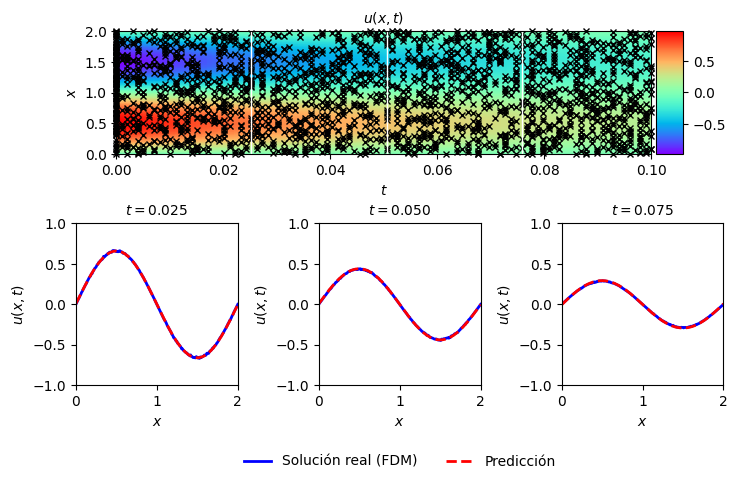

In [ ]:
plot_resultados(mesh=mesh,
                preds=preds_dict,
                train_datasets=train_datasets,
                val_dataset=val_dataset,
                file_name=f'Descubrimiento basado en datos/error_{porcentaje_error}')


In [ ]:
# Nombre del archivo CSV
file_name = f'Descubrimiento basado en datos/error_{porcentaje_error}/descubrimiento_u_pred_t_1e-8_x_1e-2_error_{porcentaje_error}.csv'

# Escribir la matriz en el archivo CSV
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(preds_dict['u'])

print(f"Matriz guardada en {file_name}")

Matriz guardada en /content/drive/MyDrive/data/Segunda vez/descubrimientos/error_1/descubrimiento_u_pred_t_1e-8_x_1e-2_error_1.csv
